---
<h1 align="center"><strong>Cálculo de dependencia cruzada para todos los países</strong></h1>
<h4 align="center"><strong>Manuel Alejandro Hidalgo y Jorge Díaz Lanchas</strong></h4>
<h4 align="center"><strong>Fundación Real Instituto Elcano</strong></h4>

---

In [8]:
import os
import gzip
import pandas as pd
import numpy as np
from numpy.linalg import inv
from tqdm import tqdm
import matplotlib.pyplot as plt
from pathlib import Path

***No ejecutar este código a menos que se quiera comprimir***

In [2]:
def comprimir_dividir_archivo(archivo_original, tamano_maximo=100, directorio_salida=None):
    # Asegúrate de que el archivo original existe
    archivo_original = Path(archivo_original)
    if not archivo_original.exists():
        raise FileNotFoundError(f"No se encuentra el archivo: {archivo_original}")
    
    # Si no se especifica directorio de salida, usar src/data/raw/ITP/
    if directorio_salida is None:
        # Obtener el directorio raíz del proyecto (donde está src/)
        proyecto_root = Path(__file__).parent.parent.parent
        directorio_salida = proyecto_root / 'src' / 'data' / 'raw' / 'ITP'
    else:
        directorio_salida = Path(directorio_salida)
    
    # Crear el directorio de salida si no existe
    directorio_salida.mkdir(parents=True, exist_ok=True)
    
    # Abre el archivo original en modo de lectura binaria
    with open(archivo_original, 'rb') as f_in:
        # Lee el contenido del archivo original
        contenido = f_in.read()
        
        # Determina el número de partes necesarias
        num_partes = (len(contenido) + tamano_maximo - 1) // tamano_maximo
        
        # Divide el contenido en partes y escribe cada parte comprimida
        for i in range(num_partes):
            parte = contenido[i * tamano_maximo: (i + 1) * tamano_maximo]
            archivo_salida = directorio_salida / f'ITPD_E_R02.csv.parte{i}.gz'
            with gzip.open(archivo_salida, 'wb') as f_out:
                f_out.write(parte)
            print(f"Parte {i} creada en: {archivo_salida}")

# Tamaño máximo por parte (1GB)
tamano_maximo = 1000 * 1024 * 1024

try:
    # Ruta al archivo original
    archivo_original = Path(r'Datos/ITP/ITPD_E_R02.csv')
    
    # Comprimir y dividir el archivo original
    comprimir_dividir_archivo(archivo_original, tamano_maximo)
    print("Proceso completado con éxito")
except Exception as e:
    print(f"Error durante el proceso: {e}")

Error durante el proceso: No se encuentra el archivo: Datos\ITP\ITPD_E_R02.csv


***Descomprimir, carga de datos y borrado de archivo***

La compresión se hace para poder trabajar con git sin porblemas de tamaño de ficheros.
Se descomprime, se importa y luego se borra el fichero descomprimido


In [3]:
"""
FASE 1: PREPARACIÓN Y CARGA DE DATOS
Este script procesa la base de datos International Trade and Production Database (ITP)
que viene dividida en múltiples archivos comprimidos
"""
def procesar_datos_itp():
    try:
        # Definición de rutas usando Path y la estructura de tu proyecto
        # Si estamos en un notebook, usamos una ruta relativa
        try:
            base_path = Path(__file__).parent.parent.parent
        except NameError:  # Estamos en un notebook
            base_path = Path.cwd().parent  # Asumiendo que el notebook está en /notebooks/

        source_directory = base_path / "src" / "data" / "raw" / "ITP"
        target_directory = base_path / "src" / "data" / "processed"
        target_filename = 'ITPD_E_R02.csv'

        # Imprimir las rutas para verificación
        print(f"Directorio fuente: {source_directory}")
        print(f"Directorio destino: {target_directory}")

        # Asegurar que los directorios existen
        target_directory.mkdir(parents=True, exist_ok=True)

        # Verificar que el directorio fuente existe
        if not source_directory.exists():
            raise FileNotFoundError(f"No se encuentra el directorio fuente: {source_directory}")

        # Listar archivos comprimidos
        chunk_filenames = sorted([f for f in os.listdir(source_directory) 
                         if f.startswith('ITPD_E_R02.csv.parte') and f.endswith('.gz')])

        # Control de errores: verificar que existen archivos para procesar
        if not chunk_filenames:
            raise FileNotFoundError(f"No se encontraron archivos .gz en {source_directory}")

        # Construir la ruta completa para el archivo combinado
        target_filepath = target_directory / target_filename

        print("Combinando archivos comprimidos...")
        with open(target_filepath, 'wb') as target_file:
            for chunk_filename in tqdm(chunk_filenames, desc="Procesando archivos"):
                chunk_filepath = source_directory / chunk_filename
                with gzip.open(chunk_filepath, 'rb') as chunk_file:
                    target_file.write(chunk_file.read())

        print("Leyendo archivo CSV...")
        # Usar chunks para manejar archivos grandes de manera eficiente
        itp = pd.read_csv(target_filepath, sep=",", chunksize=100000)
        
        # Procesar por chunks y filtrar año 2019
        chunks_2019 = []
        for chunk in tqdm(itp, desc="Filtrando datos de 2019"):
            chunk_2019 = chunk[chunk['year'] == 2019]
            chunks_2019.append(chunk_2019)
        
        # Combinar todos los chunks filtrados
        itp2019 = pd.concat(chunks_2019, ignore_index=True)

        # Limpieza: eliminar archivo temporal
        os.remove(target_filepath)
        print(f"Archivo temporal eliminado")

        # Obtener lista única de países importadores
        codigos_countries = list(itp2019['importer_iso3'].unique())
        print(f"Total de países únicos encontrados: {len(codigos_countries)}")

        return itp2019, codigos_countries

    except Exception as e:
        print(f"Error durante el procesamiento: {e}")
        raise

if __name__ == "__main__":
    try:
        data, countries = procesar_datos_itp()
        print("Procesamiento completado con éxito")
    except Exception as e:
        print(f"Error en la ejecución principal: {e}")

Directorio fuente: c:\Users\Usuario\Documents\Github\Seguridad económica\src\data\raw\ITP
Directorio destino: c:\Users\Usuario\Documents\Github\Seguridad económica\src\data\processed
Combinando archivos comprimidos...


Procesando archivos: 100%|██████████| 7/7 [01:14<00:00, 10.60s/it]


Leyendo archivo CSV...


Filtrando datos de 2019: 726it [04:24,  2.74it/s]


Archivo temporal eliminado
Total de países únicos encontrados: 237
Procesamiento completado con éxito


In [4]:
from typing import List, Dict  # Importa List y Dict

def crear_matriz_comercio(grouped_data, codigos_paises: List[str]) -> Dict[str, pd.DataFrame]:

    """
    Crea matrices de comercio bilateral para cada industria a partir de datos agrupados.

    Args:
        grouped_data: DataFrame agrupado por industria.
        codigos_paises: Lista de códigos de países ISO3.  Ahora se pasa como argumento.

    Returns:
        Dict[str, pd.DataFrame]: Diccionario de matrices de comercio.

    Raises:
        ValueError: Si faltan columnas requeridas en los datos.
    """
    matrices = {}

    required_columns = {'exporter_iso3', 'importer_iso3', 'trade'}

    if not required_columns.issubset(grouped_data.obj.columns):
        raise ValueError(f"Los datos deben contener las columnas: {required_columns}")

    for industry, group in tqdm(grouped_data, desc="Creando matrices de comercio"):
        matrix_df = pd.DataFrame(
            0.0,
            index=codigos_paises,  # Usa el argumento codigos_paises
            columns=codigos_paises   # Usa el argumento codigos_paises
        )

        valid_trades = group[
            group['exporter_iso3'].isin(codigos_paises) &  # Usa el argumento codigos_paises
            group['importer_iso3'].isin(codigos_paises)   # Usa el argumento codigos_paises
        ]

        for _, row in valid_trades.iterrows():
            matrix_df.at[row['exporter_iso3'], row['importer_iso3']] = row['trade']

        matrices[industry] = matrix_df

    return matrices

In [5]:
# Define la lista de códigos de países
codigos_paises = sorted(data['importer_iso3'].unique().tolist())

# Llama a la función con el argumento codigos_paises
matrices_comercio = crear_matriz_comercio(data.groupby('industry_descr'), codigos_paises)

Creando matrices de comercio: 100%|██████████| 170/170 [05:03<00:00,  1.79s/it]


In [47]:
mat = matrices_comercio['Wheat']

In [48]:
def eliminar_filas_columnas_cero(df, threshold_pct=0.05):
    # Calcular el total del comercio mundial
    total_trade = df.values.sum()
    
    # Calcular el umbral
    threshold = total_trade * (threshold_pct / 100)
    
    # Convertir a cero los valores por debajo del umbral
    df_filtered = df.where(df >= threshold, 0)
    
    # Ahora identificar países con todos ceros
    zero_rows = df_filtered.index[df_filtered.sum(axis=1) == 0]
    zero_cols = df_filtered.columns[df_filtered.sum(axis=0) == 0]
    countries_to_drop = list(set(zero_rows) & set(zero_cols))
    
    # Eliminar los países identificados
    mat_clean = df_filtered.drop(countries_to_drop, axis=0).drop(countries_to_drop, axis=1)
    return mat_clean
mat_clean = eliminar_filas_columnas_cero(mat)

In [83]:
import numpy as np
from itertools import combinations

def calculate_path_dependency(X_clean, path, denominators):
    """Calcula la dependencia de un camino específico."""
    # Inicializamos con el primer flujo
    flujo_actual = X_clean[path[0], path[1]]
    
    # Para cada nodo intermedio, calculamos qué proporción del flujo continúa
    for i in range(1, len(path)-1):
        nodo_actual = path[i]
        # Si el denominador es 0, no hay flujo que pueda pasar
        if denominators[nodo_actual] == 0:
            return 0
        # Calculamos qué proporción del flujo sigue al siguiente nodo
        proporcion = X_clean[path[i], path[i+1]] / denominators[nodo_actual]
        flujo_actual = flujo_actual * proporcion
    
    # Normalizamos por el denominador del país destino
    return flujo_actual / denominators[path[-1]] if denominators[path[-1]] > 0 else 0

def calculate_all_dependencies(X, country_names=None, convergence_threshold=0.01, max_possible_length=5, threshold_pct=0.1):
    """Calcula todas las dependencias entre países.
    
    Parameters:
    -----------
    X : numpy.ndarray
        Matriz de comercio entre países
    country_names : list, optional
        Lista con los nombres de los países en el mismo orden que la matriz X.
        Si no se proporciona, se usarán índices numéricos.
    convergence_threshold : float
        Umbral de convergencia para las dependencias indirectas
    max_possible_length : int
        Longitud máxima de las cadenas de dependencia
    threshold_pct : float
        Porcentaje mínimo del comercio total para considerar una relación
    """
    n = X.shape[0]
    
    # Si no se proporcionan nombres de países, usar índices
    if country_names is None:
        country_names = [f"País {i}" for i in range(n)]

    # Verificar que la longitud de country_names coincida con la dimensión de X
    if len(country_names) != n:
        raise ValueError(f"La longitud de country_names ({len(country_names)}) no coincide con la dimensión de X ({n})")

    # Preprocesamiento
    total_trade = np.sum(X)
    threshold = total_trade * (threshold_pct / 100)
    X_clean = np.where(X < threshold, 0, X)
    denominators = np.sum(X, axis=0)

    results = {
        'dependencies': [],
        'top_dependencies': [],
        'avg_dependencies': {},
        'length_distribution': np.zeros(max_possible_length),
    }
    
    for i in range(n):
        total_dep = 0.0
        num_deps = 0
        for j in range(n):
            if i != j:
                current_total = 0
                indirect_total = 0
                dependencies_by_length = {}
                length = 1

                # Dependencia directa
                trade_value = X_clean[j, i]
                direct_dependency = X_clean[j, i] / denominators[i] if denominators[i] > 0 else 0
                dependencies_by_length[1] = direct_dependency
                current_total = direct_dependency

                # Dependencias indirectas
                for length in range(2, max_possible_length + 1):
                    DI_ij_l = 0
                    middle_countries = [k for k in range(n) if k != i and k != j]

                    for intermediaries in combinations(middle_countries, length - 1):
                        path = (j,) + intermediaries + (i,)
                        fuerza_camino = calculate_path_dependency(X_clean, path, denominators)
                        DI_ij_l += fuerza_camino

                    dependencies_by_length[length] = DI_ij_l
                    indirect_total += DI_ij_l

                    prev_total = current_total
                    current_total = direct_dependency + indirect_total

                    # Convergencia
                    if length > 1 and abs(current_total - prev_total) < convergence_threshold:
                        results['length_distribution'][length - 1] += 1
                        break

                # La dependencia total es la suma de la directa y la indirecta
                total_dependency = direct_dependency + indirect_total

                result = {
                    'importador': country_names[i],
                    'exportador': country_names[j],
                    'trade_value': trade_value,
                    'dependencia_directa': direct_dependency,
                    'dependencia_indirecta': indirect_total,
                    'dependencia_total': total_dependency,
                    'longitud_optima': length,
                    'dependencias_por_longitud': dependencies_by_length
                }

                results['dependencies'].append(result)
                results['top_dependencies'].append(
                    (country_names[i], country_names[j], direct_dependency, 
                     indirect_total, total_dependency, length))
                total_dep += total_dependency
                num_deps += 1

        results['avg_dependencies'][country_names[i]] = total_dep / num_deps if num_deps > 0 else 0

    # Ordenar top dependencies
    results['top_dependencies'].sort(key=lambda x: x[4], reverse=True)
    results['top_dependencies'] = results['top_dependencies'][:90]

    return results

def analyze_dependencies(X, country_names=None):
    """Analiza las dependencias comerciales y muestra los resultados."""
    results = calculate_all_dependencies(X, country_names=country_names)
    '''
    print("\nTop dependencias más fuertes:")
    print("Importador | Exportador | Directa   | Indirecta | Total     | Long. Óptima")
    print("-" * 75)
    
    for imp_name, exp_name, dep_dir, dep_ind, dep_tot, length in results['top_dependencies']:
        print(f"{imp_name:10} | {exp_name:10} | {dep_dir:8.4f} | {dep_ind:9.4f} | {dep_tot:8.4f} | {length:12d}")
    '''
    return results
'''
if __name__ == "__main__":

    # Matriz 20x20 con más ceros y valores destacados
    X = mat_clean.values

    country_names = mat_clean.columns.tolist()

    # Ejecutar el análisis
    results = analyze_dependencies(X, country_names)
    '''

'\nif __name__ == "__main__":\n\n    # Matriz 20x20 con más ceros y valores destacados\n    X = mat_clean.values\n\n    country_names = mat_clean.columns.tolist()\n\n    # Ejecutar el análisis\n    results = analyze_dependencies(X, country_names)\n    '

In [87]:

# Diccionario para guardar todos los resultados
all_results = {}

# Procesar cada industria
for industry, mat in matrices_comercio.items():
    print(f"\nProcesando industria: {industry}")
    
    # Limpiar matriz
    mat_clean = eliminar_filas_columnas_cero(mat)
    
    # Si la matriz limpia está vacía o es muy pequeña, continuamos con la siguiente
    if mat_clean.shape[0] < 2:
        print(f"Matriz demasiado pequeña para industria {industry}")
        continue
        
    # Convertir a numpy array y obtener nombres de países
    X = mat_clean.values
    country_names = mat_clean.columns.tolist()

     
    # Calcular dependencias
    results = analyze_dependencies(X, country_names)
    
    # Guardar resultados
    all_results[industry] = {
        'results': results,
        'country_names': country_names,
        'matrix_shape': mat_clean.shape
    }


Procesando industria: Accumulators primary cells and batteries

Procesando industria: Agricultural and forestry machinery

Procesando industria: Aircraft and spacecraft

Procesando industria: Animal feed ingredients and pet foods

Procesando industria: Articles of concrete cement and plaster

Procesando industria: Automobile bodies trailers & semi-trailers

Procesando industria: Bakery products

Procesando industria: Basic chemicals except fertilizers

Procesando industria: Basic iron and steel

Procesando industria: Basic precious and non-ferrous metals

Procesando industria: Bearings gears gearing & driving elements

Procesando industria: Beverages, nec

Procesando industria: Bicycles and invalid carriages

Procesando industria: Builders' carpentry and joinery

Procesando industria: Building and repairing of ships

Procesando industria: Building/repairing of pleasure/sport. boats

Procesando industria: Carpets and rugs

Procesando industria: Cement lime and plaster

Procesando indus

In [ ]:
import pandas as pd

def create_dependencies_dataframe(all_results):
    """
    Crea un DataFrame con los resultados de dependencias para todas las industrias.
    
    Parameters:
    -----------
    all_results : dict
        Diccionario con los resultados por industria
        
    Returns:
    --------
    pandas.DataFrame
        DataFrame con las columnas: industria, importador, exportador, 
        dependencia_total, dependencia_directa, dependencia_indirecta, longitud_optima
    """
    # Lista para almacenar los datos de todas las industrias
    all_data = []
    
    # Procesar cada industria
    for industry, data in all_results.items():
        # Obtener los resultados de esta industria
        industry_results = data['results']['dependencies']
        
        # Añadir cada fila de resultados
        for result in industry_results:
            row = {
                'industria': industry,
                'importador': result['importador'],
                'exportador': result['exportador'],
                'dependencia_total': result['dependencia_total'],
                'dependencia_directa': result['dependencia_directa'],
                'dependencia_indirecta': result['dependencia_indirecta'],
                'trade_value': result['trade_value'],
                'longitud_optima': result['longitud_optima']
            }
            all_data.append(row)
    
    # Crear el DataFrame
    df = pd.DataFrame(all_data)
    
    # Ordenar el DataFrame
    df = df.sort_values(['industria', 'dependencia_total'], ascending=[True, False])
    
    return df

# Ejemplo de uso:
df = create_dependencies_dataframe(all_results)

# Definir el nuevo mapeo de nombres de columnas
nuevo_nombres = {
    'industria': 'industry',
    'importador': 'dependent_country',
    'exportador': 'supplier_country',
    'dependencia_total': 'dependency_value',
    'dependencia_directa': 'direct_dependency',
    'dependencia_indirecta': 'indirect_dependency',
    'trade_value': 'trade_value',
    'longitud_optima': 'longitud_optima'
}

# Renombrar las columnas
df = df.rename(columns=nuevo_nombres)

# Guardar como gzip
with gzip.open(r"C:\Users\Usuario\Documents\Github\Seguridad económica\src\data\processed\Dependencias consolidadas\dependencias.csv.gz", 'wt') as f:
    df.to_csv(f, sep=";", index=False)

In [ ]:


# Función para calcular la media ponderada de forma segura
def safe_weighted_average(group):
    # Si los pesos suman cero, retornamos NaN
    if group['trade_value'].sum() == 0:
        return np.nan
    return np.average(group['dependency_value'], weights=group['trade_value'])

# 1. Agrupar por dependent_country y supplier_country
weighted_dependencies = df.groupby(['dependent_country', 'supplier_country']).apply(
    safe_weighted_average
).reset_index(name='weighted_dependency')

# 2. Eliminar los NaN si quieres (opcional)
weighted_dependencies = weighted_dependencies.dropna()

# 3. Ordenar los resultados
weighted_dependencies = weighted_dependencies.sort_values(
    ['dependent_country', 'weighted_dependency'], 
    ascending=[True, False]
)

# Mostrar los primeros resultados
print("\nPrimeras 10 relaciones de dependencia:")
print(weighted_dependencies.head(10))

# Mostrar algunos stats básicos
print("\nEstadísticas básicas de las dependencias ponderadas:")
print(weighted_dependencies['weighted_dependency'].describe())

# Ver cuántas relaciones tenemos en total
print(f"\nNúmero total de relaciones bilateral: {len(weighted_dependencies)}")



Primeras 10 relaciones de dependencia:
    dependent_country supplier_country  weighted_dependency
26                AFG              CHN             1.000000
107               AFG              MYS             1.000000
159               AFG              USA             1.000000
2                 AFG              ARE             0.846083
80                AFG              KEN             0.698054
118               AFG              PAK             0.568124
79                AFG              KAZ             0.552644
69                AFG              IND             0.546171
71                AFG              IRN             0.503011
160               AFG              UZB             0.426259

Estadísticas básicas de las dependencias ponderadas:
count    3061.000000
mean        0.331082
std         0.300333
min         0.002074
25%         0.092440
50%         0.224982
75%         0.493269
max         1.000000
Name: weighted_dependency, dtype: float64

Número total de relaciones bilatera

C:\Users\Usuario\AppData\Local\Temp\ipykernel_71664\936914198.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  weighted_dependencies = df.groupby(['dependent_country', 'supplier_country']).apply(


In [1]:
import pandas as pd

# Leer el archivo CSV
# Nota: Uso sep=';' porque veo que las columnas están separadas por punto y coma
df = pd.read_csv(r"C:\Users\Usuario\Documents\Github\Seguridad económica\src\data\processed\Dependencias consolidadas\dependencias.csv\dependencias.csv", sep=';')

# Definir las columnas a revisar
columnas_check = ['dependency_value', 'direct_dependency', 'indirect_dependency', 'trade_value']

# Eliminar las filas donde todas las columnas especificadas son 0
df_limpio = df[~(df[columnas_check] == 0).all(axis=1)]

# Guardar el resultado en un nuevo archivo
# Lo guardamos en la misma ubicación pero con un nombre diferente
ruta_salida = r"C:\Users\Usuario\Documents\Github\Seguridad económica\src\data\processed\Dependencias consolidadas\dependencias_limpio.csv"
df_limpio.to_csv(ruta_salida, sep=';', index=False)

# Imprimir información sobre el proceso
print(f"Registros originales: {len(df)}")
print(f"Registros después de eliminar filas con ceros: {len(df_limpio)}")
print(f"Se eliminaron {len(df) - len(df_limpio)} registros")

Registros originales: 738520
Registros después de eliminar filas con ceros: 76747
Se eliminaron 661773 registros


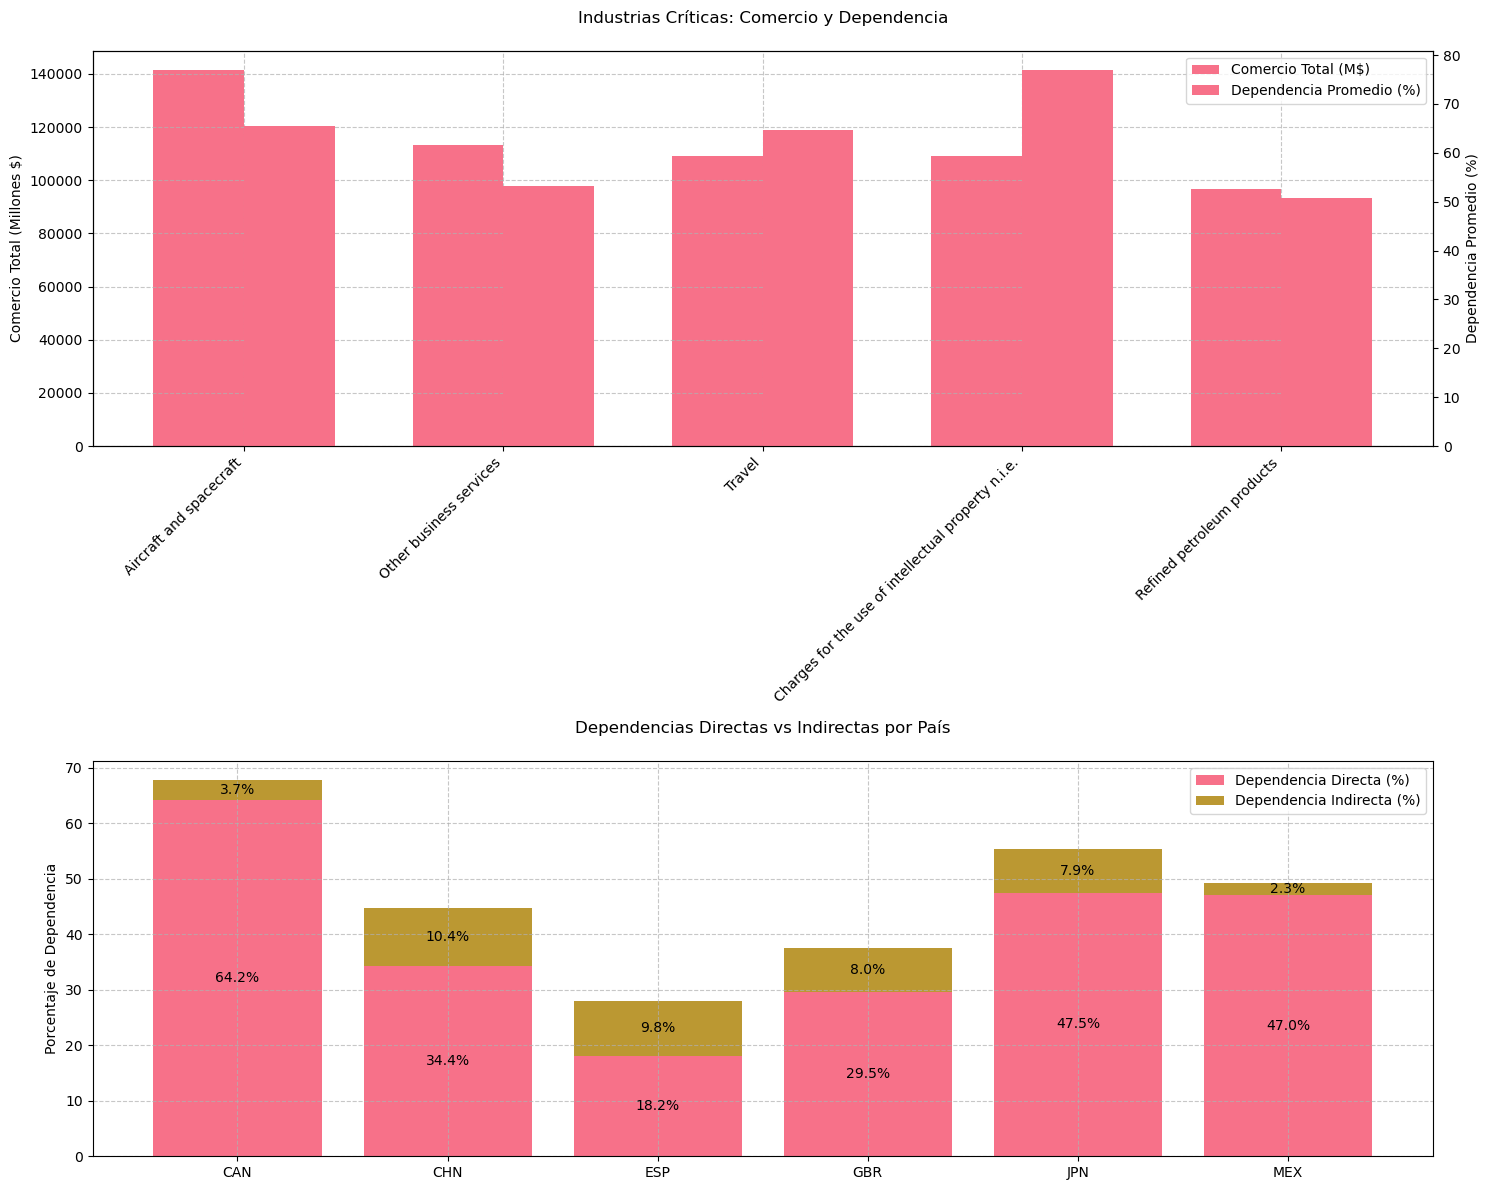


Industrias Críticas:
                                              industry    trade_value  \
2                              Aircraft and spacecraft  141643.443059   
83                             Other business services  113227.000000   
148                                             Travel  109240.000000   
19   Charges for the use of intellectual property n...  109179.000000   
123                         Refined petroleum products   96625.813778   

     dependency_value  dependent_country  
2            0.655443                 40  
83           0.532370                  8  
148          0.646122                 20  
19           0.770399                 37  
123          0.507046                 48  

Dependencias por País:
  dependent_country    trade_value  direct_dependency  indirect_dependency
0               CAN  285998.955024           0.641582             0.036970
1               CHN  171114.228129           0.343742             0.103900
2               ESP   15004.5259

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Leer el CSV
df = df_limpio

# 1. Preparar datos para el primer gráfico - Industrias críticas
industrias_criticas = df[df['supplier_country'] == 'USA'].groupby('industry').agg({
    'trade_value': 'sum',
    'dependency_value': lambda x: np.average(x, weights=df.loc[x.index, 'trade_value']),
    'dependent_country': 'nunique'
}).reset_index()

# Filtrar industrias críticas
industrias_criticas = industrias_criticas[
    (industrias_criticas['dependency_value'] > 0.5) & 
    (industrias_criticas['trade_value'] > 50000)
].sort_values('trade_value', ascending=False).head(5)

# 2. Preparar datos para el segundo gráfico - Dependencias por país
paises_interes = ['CAN', 'MEX', 'CHN', 'JPN', 'GBR', 'ESP']
dependencias_pais = df[
    (df['supplier_country'] == 'USA') & 
    (df['dependent_country'].isin(paises_interes))
].groupby('dependent_country').agg({
    'trade_value': 'sum',
    'direct_dependency': lambda x: np.average(x, weights=df.loc[x.index, 'trade_value']),
    'indirect_dependency': lambda x: np.average(x, weights=df.loc[x.index, 'trade_value'])
}).reset_index()

# Configuración del estilo
plt.style.use('default')  # Usando el estilo default de matplotlib
sns.set_palette("husl")   # Usando una paleta de colores de seaborn

# Crear los gráficos
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

# 1. Gráfico de industrias críticas
x = range(len(industrias_criticas))
width = 0.35

# Añadir cuadrícula
ax1.grid(True, linestyle='--', alpha=0.7)

bars1 = ax1.bar([i - width/2 for i in x], industrias_criticas['trade_value'], 
                width, label='Comercio Total (M$)')
ax2_twin = ax1.twinx()
bars2 = ax2_twin.bar([i + width/2 for i in x], industrias_criticas['dependency_value'] * 100, 
                     width, label='Dependencia Promedio (%)')

# Configuración del primer gráfico
ax1.set_ylabel('Comercio Total (Millones $)', fontsize=10)
ax2_twin.set_ylabel('Dependencia Promedio (%)', fontsize=10)
ax1.set_title('Industrias Críticas: Comercio y Dependencia', fontsize=12, pad=20)
ax1.set_xticks(x)
ax1.set_xticklabels(industrias_criticas['industry'], rotation=45, ha='right')

# Añadir leyendas
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2_twin.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

# 2. Gráfico de dependencias por país
ax2.grid(True, linestyle='--', alpha=0.7)

bottom_bars = ax2.bar(dependencias_pais['dependent_country'], 
                     dependencias_pais['direct_dependency'] * 100, 
                     label='Dependencia Directa (%)')

top_bars = ax2.bar(dependencias_pais['dependent_country'], 
                   dependencias_pais['indirect_dependency'] * 100,
                   bottom=dependencias_pais['direct_dependency'] * 100, 
                   label='Dependencia Indirecta (%)')

# Configuración del segundo gráfico
ax2.set_ylabel('Porcentaje de Dependencia', fontsize=10)
ax2.set_title('Dependencias Directas vs Indirectas por País', fontsize=12, pad=20)
ax2.legend()

# Ajustar etiquetas del eje x
plt.xticks(rotation=45, ha='right')

# Añadir valores sobre las barras en el segundo gráfico
for bars in [bottom_bars, top_bars]:
    for bar in bars:
        height = bar.get_height()
        if height > 0:  # Solo mostrar etiquetas para valores positivos
            ax2.text(bar.get_x() + bar.get_width()/2., 
                    bar.get_y() + height/2.,
                    f'{height:.1f}%',
                    ha='center', va='center')

# Ajustar layout
plt.tight_layout()

# Mostrar gráficos
plt.show()

# Imprimir las tablas de datos calculados
print("\nIndustrias Críticas:")
print(industrias_criticas)
print("\nDependencias por País:")
print(dependencias_pais)


Top 6 industrias por país con mayor dependencia ponderada de USA:
                                           industry  trade_value  dependency_value  direct_dependency  indirect_dependency country
                                     Motor vehicles     33986.97             77.32              67.39                 9.93     CAN
                                             Travel     17363.00             89.50              89.50                 0.00     CAN
                            Other business services     14828.00            100.00             100.00                 0.00     CAN
         Extraction crude petroleum and natural gas     12675.19             84.61              84.61                 0.00     CAN
                         Refined petroleum products     10467.18             88.89              88.18                 0.71     CAN
                                          Transport      8269.00            100.00             100.00                 0.00     CAN
                

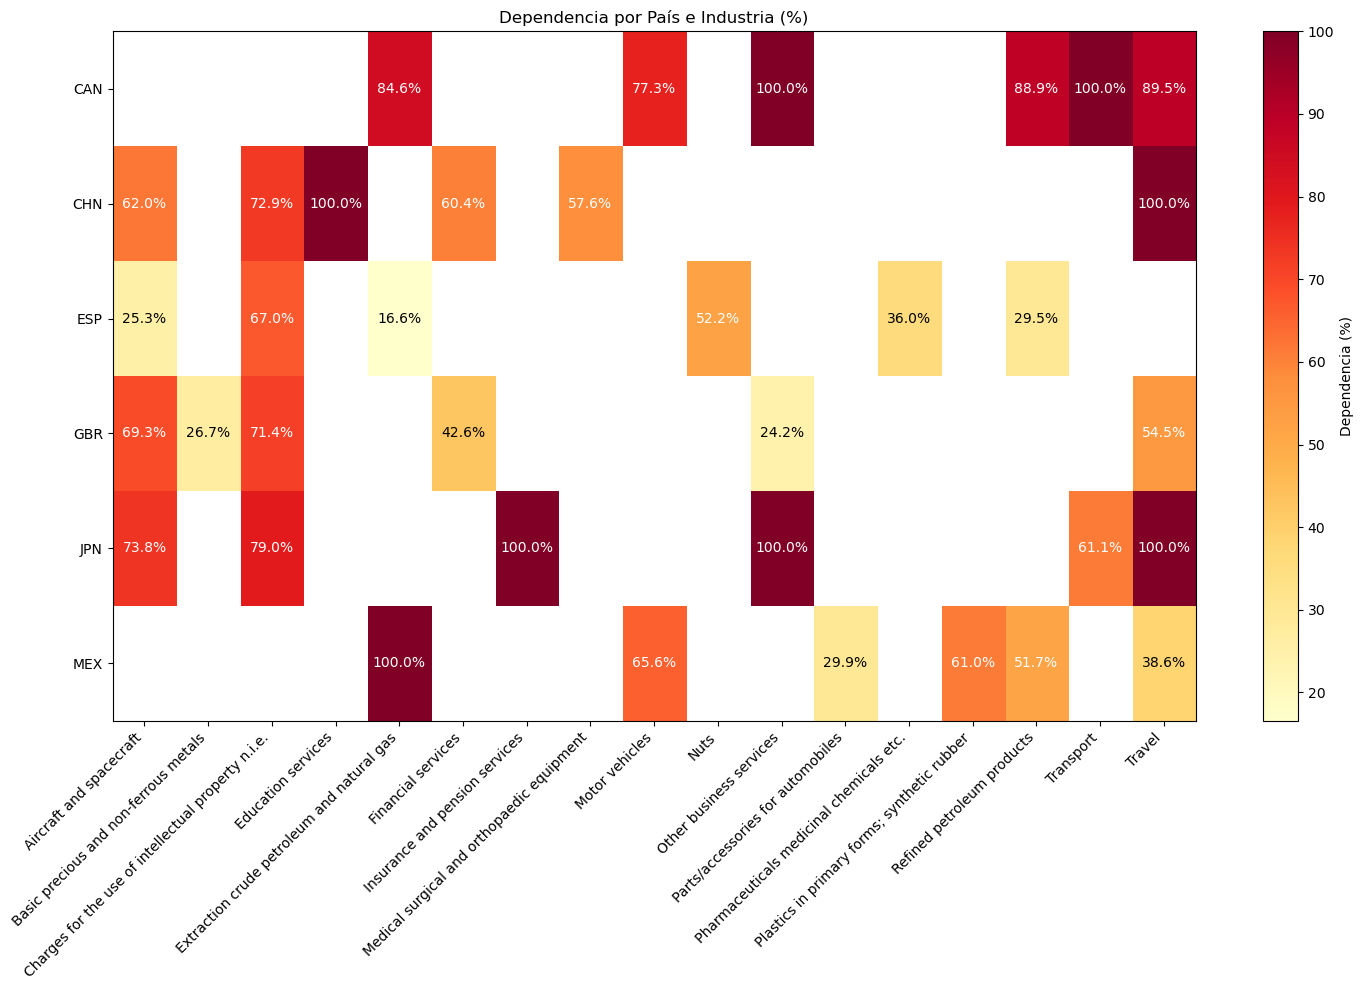

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Leer el CSV
df = df_limpio


# Lista de países de interés
paises_interes = ['CAN', 'MEX', 'CHN', 'JPN', 'GBR', 'ESP']

# Crear un DataFrame con las principales dependencias por país
top_dependencies = []

for pais in paises_interes:
    # Filtrar datos para el país y USA como proveedor
    country_data = df[(df['dependent_country'] == pais) & 
                     (df['supplier_country'] == 'USA')]
    
    # Calcular dependencia total ponderada por valor comercial
    country_top = (country_data
                  .assign(total_dependency=lambda x: x['dependency_value'],
                         weighted_dependency=lambda x: x['dependency_value'] * x['trade_value'])
                  .nlargest(6, 'weighted_dependency')
                  [['industry', 'trade_value', 'dependency_value', 
                    'direct_dependency', 'indirect_dependency']]
                  .assign(country=pais))
    
    top_dependencies.append(country_top)

# Combinar todos los resultados
result_df = pd.concat(top_dependencies)

# Formatear los valores para mejor visualización
result_df['trade_value'] = result_df['trade_value'].round(2)
result_df['dependency_value'] = (result_df['dependency_value'] * 100).round(2)
result_df['direct_dependency'] = (result_df['direct_dependency'] * 100).round(2)
result_df['indirect_dependency'] = (result_df['indirect_dependency'] * 100).round(2)

# Mostrar la tabla
print("\nTop 6 industrias por país con mayor dependencia ponderada de USA:")
print(result_df.to_string(index=False))

# Crear visualización
plt.figure(figsize=(15, 10))

# Crear un heatmap usando plt.imshow
pivot_data = result_df.pivot(index='country', 
                           columns='industry', 
                           values='dependency_value')

plt.imshow(pivot_data, aspect='auto', cmap='YlOrRd')
plt.colorbar(label='Dependencia (%)')

# Configurar ejes
plt.xticks(range(len(pivot_data.columns)), 
           pivot_data.columns, 
           rotation=45, 
           ha='right')
plt.yticks(range(len(pivot_data.index)), 
           pivot_data.index)

# Añadir valores en cada celda
for i in range(len(pivot_data.index)):
    for j in range(len(pivot_data.columns)):
        value = pivot_data.iloc[i, j]
        if not np.isnan(value):
            plt.text(j, i, f'{value:.1f}%',
                    ha='center', va='center',
                    color='black' if value < 50 else 'white')

plt.title('Dependencia por País e Industria (%)')
plt.tight_layout()
plt.show()

# Guardar los resultados en un CSV
result_df.to_csv('top_dependencies_by_country.csv', index=False)